In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils

import process_data
import config
import network
import net_local

In [27]:
from sklearn.neighbors import NearestNeighbors

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')

In [4]:
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [5]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
# n_all_100307 = np.loadtxt('/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/interpolated_bvec_100307.txt').T

In [619]:

selected_indice = [2, 4, 5, 6, 7, 8, 9, 10, 11, 20, 21, 23, 25, 27, 30, 31, 33, 37, 38, 40, 41, 44, 45, 46, 47, 49, 53, 54, 56, 61, 62, 66, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 84, 88, 89, 92, 93, 94, 96, 97, 99, 101, 103, 104, 106, 107, 108, 109, 111, 117, 118, 119, 120, 121, 125, 126, 130, 131, 133, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 152, 155, 156, 158, 159, 161, 162, 164, 166, 170, 171, 174, 175, 177, 178, 179, 180, 182, 184, 185, 186, 187, 189, 193, 197, 199, 200, 201, 202, 205, 210, 211, 213, 214, 215, 221, 223, 226, 232, 238, 244, 246, 247, 249, 250, 251, 254, 257, 263, 270, 276, 280, 282, 284, 285]


In [620]:
bvals_100307_selected = bvals_all_100307[selected_indice]*1e-3
normalized_scan_100307_sub = normalized_scan_100307_full[:,selected_indice]
n_100307_sub = n_all_100307[:,selected_indice]

big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(135, 3)


In [621]:

net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub, device)
state_dict = torch.load("/Users/weiwenhua/UG_Project_Remote/PRO/135m/07-local/model_6af38967-98bd-4562-918f-e064464fe2d2.pt", map_location=torch.device('cpu'))
net.load_state_dict(state_dict)
net.eval()


# net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub, device)
# state_dict = torch.load("/Users/weiwenhua/UG_Project_Local/model_52e8318e-4484-417f-9213-f88234167073.pt", map_location=torch.device('cpu'))
# net.load_state_dict(state_dict)
# net.eval()


# net = net_local.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
# net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_half_01.pt"))
# net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=135, out_features=135, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=135, out_features=135, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=135, out_features=5, bias=True)
  )
)

In [622]:
now = datetime.datetime.now()
print("Current time: ", now)

with torch.no_grad():
    X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)))


now = datetime.datetime.now()
print("Current time: ", now)

Current time:  2023-04-13 13:56:39.909560
Current time:  2023-04-13 13:56:47.589574


## Parameter Maps -Subsampling

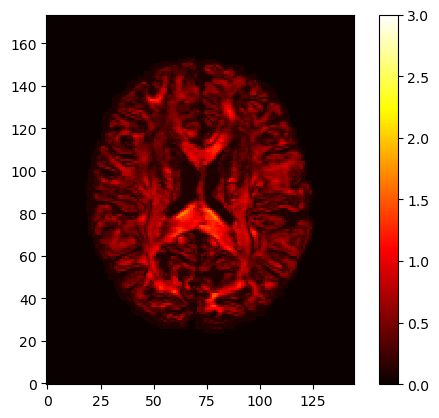

In [623]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

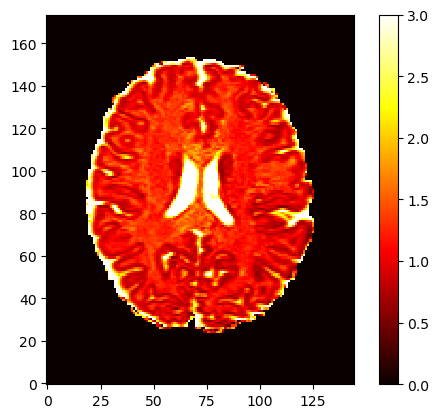

In [624]:
lambda_iso_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

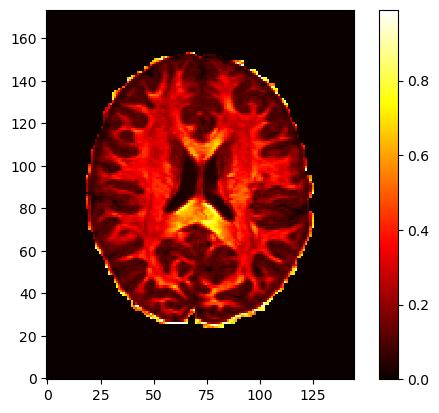

In [616]:
volume_0_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred, (145, 174, 145))
im = plt.imshow(volume_0_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

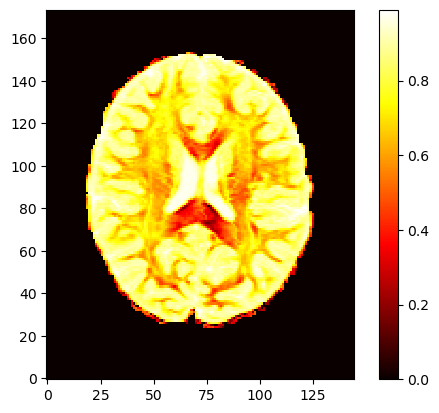

In [617]:
volume_1_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_1_100307_pred, (145, 174, 145))
im = plt.imshow(volume_1_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


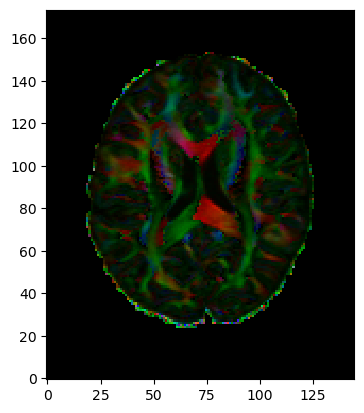

In [618]:
mask_for_mu = np.repeat(mask_100307_long_pro, 3, axis=1)
no_bg_indices = np.argwhere(mask_for_mu == 1)
resume_mu_100307 = np.copy(mask_for_mu)
mu_cart_100307_pred_cp = np.copy(mu_cart_100307_pred.T.detach().numpy())

for i, index in enumerate(no_bg_indices):
    try:
        resume_mu_100307[index[0], index[1]] = mu_cart_100307_pred_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break
        
mu_100307_reshaped = resume_mu_100307.reshape((145, 174, 145, 3))

volume_0_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred, (145, 174, 145))
volume_0_100307_slice = volume_0_100307_pred_3d[:,:,70]
r = np.repeat(volume_0_100307_slice[:, :, np.newaxis], 3, axis=2)
dir = mu_100307_reshaped[:,:,70,:] * r

plt.imshow(np.rot90(dir, 3), origin='lower', interpolation='nearest')

## Golden STD

In [15]:
big_b_indices_100307 = np.where(bvals_all_100307 != 5.)[0]

bvals_100307_no_b5 = bvals_all_100307[big_b_indices_100307]*1e-3
normalized_scan_100307_no_b5 = normalized_scan_100307_full[:, big_b_indices_100307]
n_100307_no_b5 = n_all_100307[:,big_b_indices_100307].T

b_values_100307 = torch.FloatTensor(bvals_100307_no_b5)
gradient_directions_100307 = torch.FloatTensor(n_100307_no_b5)

In [106]:
net_golden_std = net_local.BallStickNet(gradient_directions_100307, b_values_100307)
net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
net_golden_std.eval()


BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [107]:
with torch.no_grad():
    X_100307_pred_gstd,theta_100307_pred_gstd, phi_100307_pred_gstd, mu_cart_100307_pred_gstd, lambda_par_100307_pred_gstd, lambda_iso_100307_pred_gstd, volume_0_100307_pred_gstd, volume_1_100307_pred_gstd = net_golden_std(torch.from_numpy(normalized_scan_100307_no_b5.astype(np.float32)))

In [108]:
lambda_par_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred_gstd, (145, 174, 145))
lambda_iso_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred_gstd, (145, 174, 145))
volume_0_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred_gstd, (145, 174, 145))
volume_1_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, volume_1_100307_pred_gstd, (145, 174, 145))

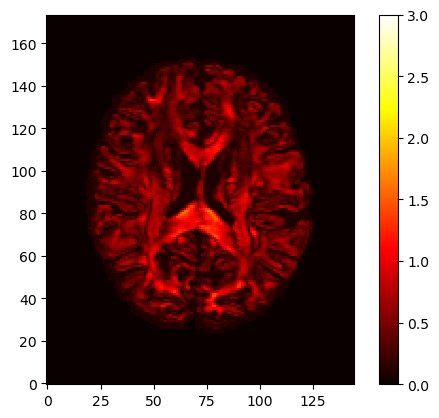

In [109]:
im = plt.imshow(lambda_par_100307_pred_gstd_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

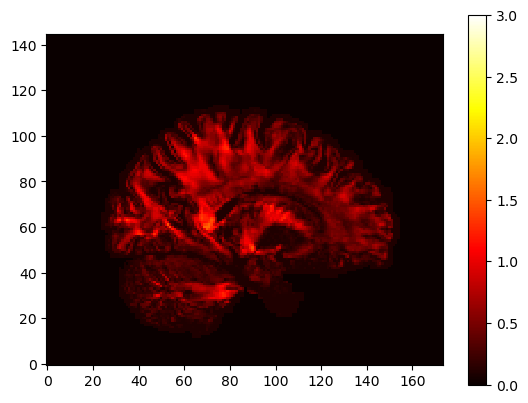

In [589]:
im = plt.imshow(lambda_par_100307_pred_gstd_3d[58,:,:].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

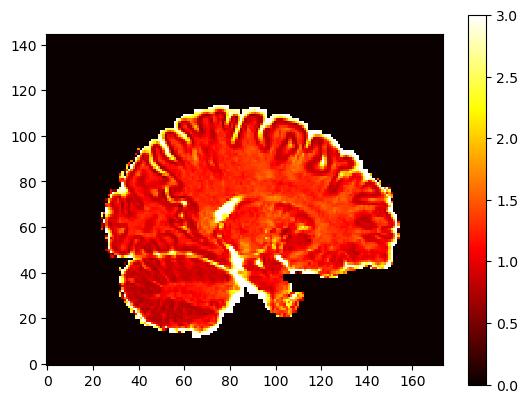

In [590]:
im = plt.imshow(lambda_iso_100307_pred_gstd_3d[58,:,:].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


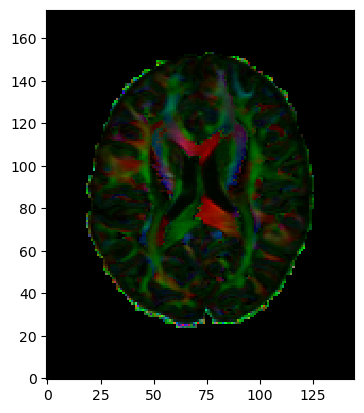

In [110]:
resume_mu_100307_gstd = np.copy(mask_for_mu)
mu_cart_100307_pred_gstd_cp = np.copy(mu_cart_100307_pred_gstd.T.detach().numpy())

for i, index in enumerate(no_bg_indices):
    try:
        resume_mu_100307_gstd[index[0], index[1]] = mu_cart_100307_pred_gstd_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break
        
mu_100307_reshaped_gstd = resume_mu_100307_gstd.reshape((145, 174, 145, 3))

volume_0_100307_gstd_slice = volume_0_100307_pred_gstd_3d[:,:,70]
r_gstd = np.repeat(volume_0_100307_gstd_slice[:, :, np.newaxis], 3, axis=2)
dir_map_gstd = mu_100307_reshaped_gstd[:,:,70,:] * r_gstd

plt.imshow(np.rot90(dir_map_gstd, 3), origin='lower', interpolation='nearest')

# Parameters Eval

In [22]:
mse = torch.nn.MSELoss(reduction='mean')

In [612]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0035)
tensor(0.0087)
tensor(0.0002)
tensor(0.0002)


In [24]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [613]:
output = cos(mu_cart_100307_pred_gstd, mu_cart_100307_pred)
print(torch.mean(output))
print(torch.std(output))

tensor(0.9195)
tensor(0.2172)


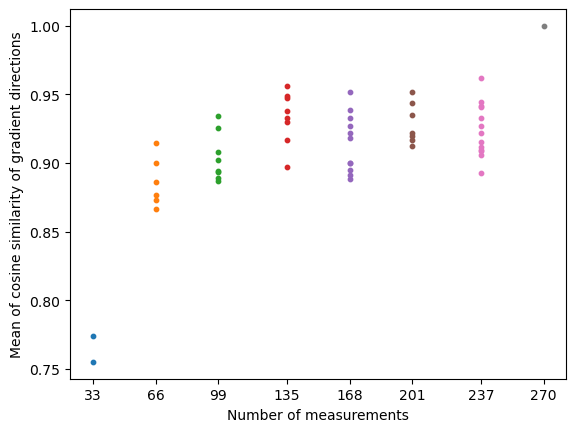

In [628]:

sub_33 = [0.7739,0.7550]
sub_66 = [0.8767,0.8668,0.8998,0.8734,0.9147,0.8862]
sub_99 = [0.8936,0.9082,0.9258,0.9023,0.8892,0.9344,0.8871,0.8939]
sub_135 = [0.9168,0.9491,0.9332,0.8970,0.9298,0.9559,0.9474,0.9383]
# sub_168 = [0.9515,0.9268,0.8951,0.8887,0.9329,0.9389,0.7532,0.9001,0.8916,0.9221,0.9180]
sub_168 = [0.9515,0.9268,0.8951,0.8887,0.9329,0.9389,0.9002,0.9001,0.8916,0.9221,0.9180]
sub_201 = [0.9220,0.9124,0.9518,0.9200,0.9439,0.9167,0.9352]
sub_237 = [0.9416,0.9446,0.9087,0.9273,0.9219,0.9058,0.9411,
           0.8929,0.9098,0.9331,0.9116,0.9623,0.9151]
full_270 = [1.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10)
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('Mean of cosine similarity of gradient directions')

ax.set_xticks(x_values)

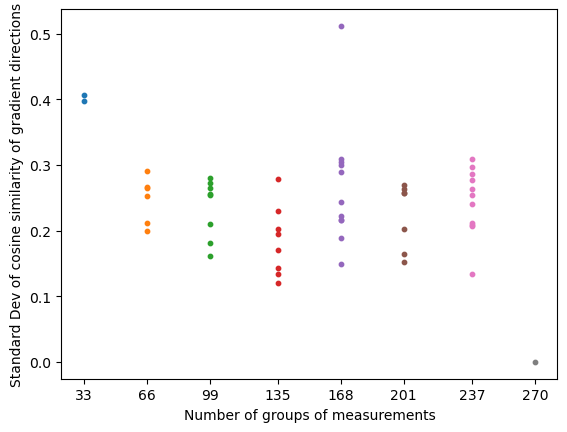

In [559]:

sub_33 = [0.3974,0.4062]
sub_66 = [0.2657,0.2531,0.2111,0.2915,0.1995,0.2647]
sub_99 = [0.2725,0.2101,0.1809,0.2552,0.2804,0.1619,0.2545,0.2653]
sub_135 = [0.2294,0.1430,0.2022,0.2792,0.1941,0.1203,0.1341,0.1697]
sub_168 = [0.1490,0.2161,0.3005,0.3090,0.2164,0.1892,0.5117,0.2889,0.3039,0.2227,0.2430]
sub_201 = [0.2573,0.2688,0.1641,0.2574,0.1523,0.2631,0.2020]
sub_237 = [0.2092, 0.2071,0.2540,0.2407,0.2638,0.2964,0.2113,0.3094,0.2857,0.1340,0.2770]
full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10)
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('Standard Dev of cosine similarity of gradient directions')

ax.set_xticks(x_values)

(array([ 35619.,  10156.,   8741.,   8826.,   9828.,  11695.,  15175.,
         22487.,  43162., 574456.]),
 array([-9.99999404e-01, -7.99999475e-01, -5.99999487e-01, -3.99999559e-01,
        -1.99999601e-01,  3.57627869e-07,  2.00000316e-01,  4.00000274e-01,
         6.00000203e-01,  8.00000191e-01,  1.00000012e+00]),
 <BarContainer object of 10 artists>)

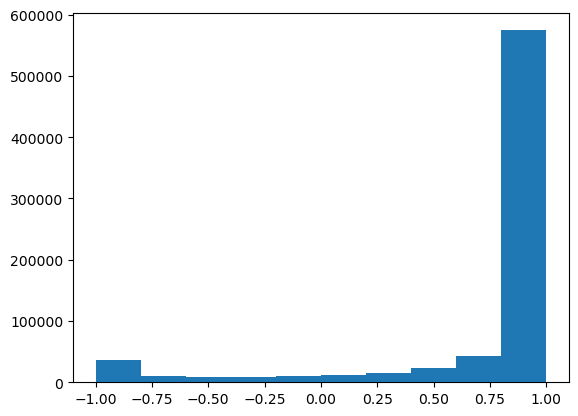

In [56]:
plt.hist(output.detach().numpy())

In [ ]:
tensor(0.0038)
tensor(0.0024)
tensor(0.0002)
tensor(0.0002)

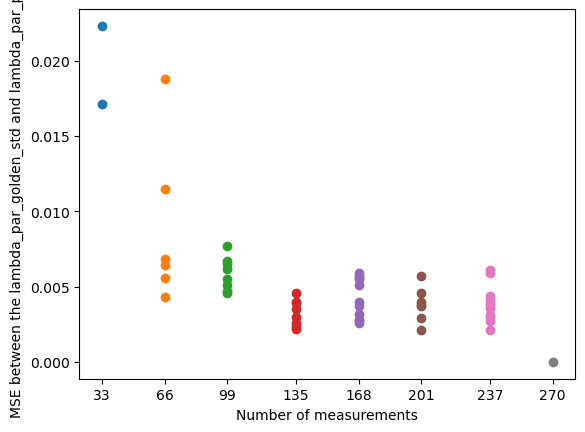

In [586]:

sub_33 = [0.0171,0.0223]
sub_66 = [0.0115,0.0188,0.0068,0.0064,0.0043,0.0056]
sub_99 = [0.0055,0.0051,0.0047,0.0046,0.0067,0.0062,0.0077,0.0065]
sub_135 = [0.0040,0.0024,0.0039,0.0046,0.0030,0.0022,0.0035,0.0026]
sub_168 = [0.0028,0.0032,0.0051,0.0055,0.0040,0.0026,0.0057,0.0059,0.0056,0.0028,0.0037]
sub_201 = [0.0037,0.0057,0.0021,0.0040,0.0046,0.0038,0.0029]
sub_237 = [0.0031,0.0061,0.0059,0.0036,0.0042,0.0027,0.0030,0.0044,0.0039,0.0021,0.0038]
full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE between the lambda_par_golden_std and lambda_par_pred')

ax.set_xticks(x_values)

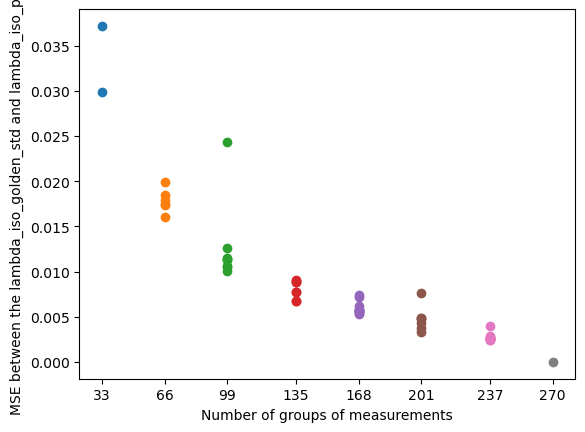

In [629]:

sub_33 = [0.0299,0.0372]
sub_66 = [0.0179,0.0199,0.0175,0.0160,0.0185,0.0174]
sub_99 = [0.0244,0.0114,0.0101,0.0113,0.0126,0.0106,0.0105,0.0115]
sub_135 = [0.0088,0.0068,0.0077,0.0091,0.0088,0.0068,0.0090,0.0077]
# sub_168 = [0.0056,0.0054,0.0056,0.0062,0.0058,0.0055,0.0199,0.0074,0.0057,0.0057,0.0053]
sub_168 = [0.0056,0.0054,0.0056,0.0062,0.0058,0.0055,0.0072,0.0074,0.0057,0.0057,0.0053]
sub_201 = [0.0049,0.0076,0.0049,0.0038,0.0048,0.0033,0.0043]
sub_237 = [0.0026,0.0026,0.0040,0.0025,0.0026,0.0025,0.0029,0.0024,0.0027,0.0027,0.0024]
full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_iso_golden_std and lambda_iso_pred')

ax.set_xticks(x_values)

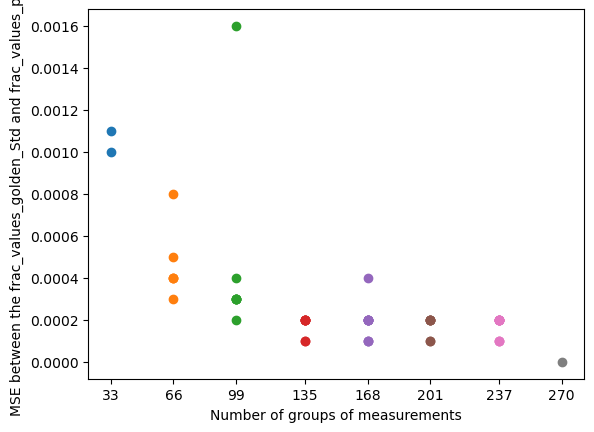

In [630]:

sub_33 = [0.0010,0.0011]
sub_66 = [0.0005,0.0008,0.0004,0.0004,0.0003,0.0004]
sub_99 = [0.0016,0.0003,0.0002,0.0003,0.0003,0.0003,0.0003,0.0004]
sub_135 = [0.0002,0.0001,0.0002,0.0002,0.0002,0.0001,0.0002,0.0002]
# sub_168 = [0.0001,0.0002,0.0002,0.0002,0.0001,0.0001,0.0014,0.0002,0.0002,0.0002,0.0002]
sub_168 = [0.0001,0.0002,0.0002,0.0002,0.0001,0.0001,0.0004,0.0002,0.0002,0.0002,0.0002]
sub_201 = [0.0002,0.0002,0.0001,0.0002,0.0002,0.0002,0.0001]
sub_237 = [0.0002,0.0002,0.0002,0.0002,0.0002,0.0001,0.0001,0.0002,0.0002,9.8879e-05,0.0002]
full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the frac_values_golden_Std and frac_values_pred')

ax.set_xticks(x_values)

# Distribution of gradient directions

In [546]:
nearest_neighbors = NearestNeighbors(n_neighbors=2)
nearest_neighbors.fit(n_100307_sub_no_b5)

# Find the distances and indices of the nearest neighbors
distances, indices = nearest_neighbors.kneighbors(n_100307_sub_no_b5)

# Get the second column of the distances array (the first column contains the distance to itself, which is 0)
nearest_neighbor_distances = distances[:, 1]

# Print the nearest neighbor distances
# print("Nearest neighbor distances:", nearest_neighbor_distances)

# Calculate the mean and standard deviation of the nearest neighbor distances
mean_distance = np.mean(nearest_neighbor_distances)
std_distance = np.std(nearest_neighbor_distances)

print("Mean distance:", mean_distance)
print("Standard deviation:", std_distance)

Mean distance: 0.12959761640779505
Standard deviation: 0.05724986363310161


135 measurements
01-local
Mean distance: 0.16776589526796468
Standard deviation: 0.07232007108745024

02-local
Mean distance: 0.16822390362071013
Standard deviation: 0.07695469845287543

04-local
Mean distance: 0.16303800274163724
Standard deviation: 0.06541720783608665

05-local
Mean distance: 0.16361244780137726
Standard deviation: 0.07509221662815983

06-local
Mean distance: 0.15968476446223404
Standard deviation: 0.0805407954702558

07-local
Mean distance: 0.16892103481319073
Standard deviation: 0.060725968462186225

08-local
Mean distance: 0.16606656931763666
Standard deviation: 0.07372463261521457

11-local
Mean distance: 0.15869640089369028
Standard deviation: 0.07206820783291618

168m
01
Mean distance: 0.15412585122851616
Standard deviation: 0.06701622046987914

03
Mean distance: 0.14500697932888898
Standard deviation: 0.06980772927426462

04
Mean distance: 0.14730623266865903
Standard deviation: 0.06793950968024344

05
Mean distance: 0.15206151693011205
Standard deviation: 0.06089566553415581

06
Mean distance: 0.14884438649303872
Standard deviation: 0.060057014995317765

07
Mean distance: 0.14512077179986246
Standard deviation: 0.06531145445213053

08
Mean distance: 0.14553547396177147
Standard deviation: 0.06824560820944671

09
Mean distance: 0.14768506850315832
Standard deviation: 0.07256156282871808

11
Mean distance: 0.14864640367832482
Standard deviation: 0.06532122458752283

12
Mean distance: 0.15270215315508337
Standard deviation: 0.06454925113124892

13
Mean distance: 0.15034019241426883
Standard deviation: 0.0700299294257983

201m
01
Mean distance: 0.14008794697982363
Standard deviation: 0.05760718995015504

02
Mean distance: 0.13974523544733108
Standard deviation: 0.062340953429278693

03
Mean distance: 0.14539200074657857
Standard deviation: 0.061801253746773324

04
Mean distance: 0.14143537193961994
Standard deviation: 0.059584202744013236

07
Mean distance: 0.13927364309157894
Standard deviation: 0.06030411716540579

08
Mean distance: 0.1418327996504944
Standard deviation: 0.06051853284026758

09
Mean distance: 0.14047991768206158
Standard deviation: 0.06027431330545529

237m
01
Mean distance: 0.1310891157270204
Standard deviation: 0.05777527569854491

02
Mean distance: 0.13416907202254238
Standard deviation: 0.05688205181356614

03
Mean distance: 0.13060509476133295
Standard deviation: 0.05755544471320064

04
Mean distance: 0.1343806529106556
Standard deviation: 0.05594612213178306

06
Mean distance: 0.13443380785383383
Standard deviation: 0.05570177469707509

07
Mean distance: 0.1313331987698815
Standard deviation: 0.05694899596938852

08
Mean distance: 0.12949725388510328
Standard deviation: 0.05681184242440935

09
Mean distance: 0.12923059379208598
Standard deviation: 0.05822335192520666

10
Mean distance: 0.1326531946242116
Standard deviation: 0.0568855753624779

11
Mean distance: 0.133675779144559
Standard deviation: 0.05675359971804299

12
Mean distance: 0.12959761640779505
Standard deviation: 0.05724986363310161

33m
01
Mean distance: 0.3094175585499336
Standard deviation: 0.1533383523863948

02
Mean distance: 0.3332950578996729
Standard deviation: 0.1388689373975564

66m
01
Mean distance: 0.2130728252012264
Standard deviation: 0.09664001560984269

02
Mean distance: 0.234104790659622
Standard deviation: 0.1322270270147293

03
Mean distance: 0.21946788586971583
Standard deviation: 0.11738371073856961

04
Mean distance: 0.224324103851117
Standard deviation: 0.08107647118073491

05
Mean distance: 0.22116186722460546
Standard deviation: 0.09348623709053214

07
Mean distance: 0.23449779331763335
Standard deviation: 0.11406944445338088


99m
01
Mean distance: 0.18365228553391036
Standard deviation: 0.08262021271755657

02
Mean distance: 0.17529134312232966
Standard deviation: 0.08635666804441514

03
Mean distance: 0.18523194797823986
Standard deviation: 0.08271312820629806

04
Mean distance: 0.18718360660794484
Standard deviation: 0.0893415051077544

05
Mean distance: 0.19359438610284208
Standard deviation: 0.0958447801119927

06
Mean distance: 0.21161416729195068
Standard deviation: 0.08573707573210028

07
Mean distance: 0.1861573502126561
Standard deviation: 0.09037068629365574

08
Mean distance: 0.18111031213593837
Standard deviation: 0.08247466564212642

# SSIM and MSE for parameter maps

In [29]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [30]:
def get_ssim_mse(pmap1, pmap2):
    ssim_val = ssim(pmap1, pmap2)
    mse_val = mean_squared_error(pmap1, pmap2)
    return ssim_val, mse_val

In [627]:
lambda_par_100307_pred_gstd_3d.shape

(145, 174, 145)

In [576]:
print(get_ssim_mse(lambda_par_100307_pred_gstd_3d, lambda_par_100307_pred_3d))
print(get_ssim_mse(lambda_iso_100307_pred_gstd_3d, lambda_iso_100307_pred_3d))
print(get_ssim_mse(volume_0_100307_pred_gstd_3d, volume_0_100307_pred_3d))
print(get_ssim_mse(volume_1_100307_pred_gstd_3d, volume_1_100307_pred_3d))

ssim_val_dir_map = ssim(dir_map_gstd, dir, channel_axis=2)
mse_val_dir_map = mean_squared_error(dir_map_gstd, dir)
print(ssim_val_dir_map, mse_val_dir_map)

(0.9738059845659093, 0.0015554870866109395)
(0.9932076536044981, 0.0021240797197637634)
(0.9968457247405624, 5.919953560010941e-05)
(0.9970113175861106, 5.919953547369495e-05)
0.8842776408656653 0.0030630665077039515


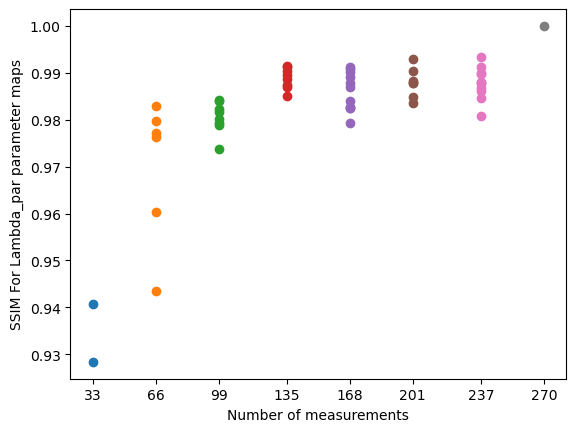

In [563]:

sub_33 = [0.9408079730313061,0.9283737223420526]
sub_66 = [0.9603050365387841,0.9435894555555315,0.9770886441605771,
          0.976358519104759,0.9828318927759545,0.9796957438747812]
sub_99 = [0.981687427501743,0.9823401833552099,0.9841646654762451,
          0.9839208253354159,0.9787783469152002,0.980223737383996,
          0.9738059845659093,0.9792406208281325]
sub_135 = [0.987503406294192,0.9911868438772247,0.9869048976443535,
           0.9850784831027479,0.9894636546168087,0.9913533710990359,
           0.9886324737585792,0.9904211687167419]

sub_168 = [0.9908086744667921,0.9890086614321913,0.9840926652387074,
          0.9827636988382996,0.9869542265297916,0.9912399438221592,
           0.9792974693725714,0.9826059510653077,0.9824730662022788,
           0.9902665689767632,0.9878388638851047]

sub_201 = [0.9883500264273777,0.9835282057796536,0.9930064606066995,
           0.9877572291568374,0.9849410231191705,0.9877641359030278,
           0.9904068361995633]
sub_237 = [0.989857123841781,0.984669045491404,0.9808404303844498,
           0.9878338380927472,0.9867464829249595,0.9912203345960794,
           0.9899866588966624,0.9861171468994328,0.9877836916588837,
           0.9933518978580425,0.9880717067317802]

full_270 = [1.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM For Lambda_par parameter maps')
ax.set_xticks(x_values)

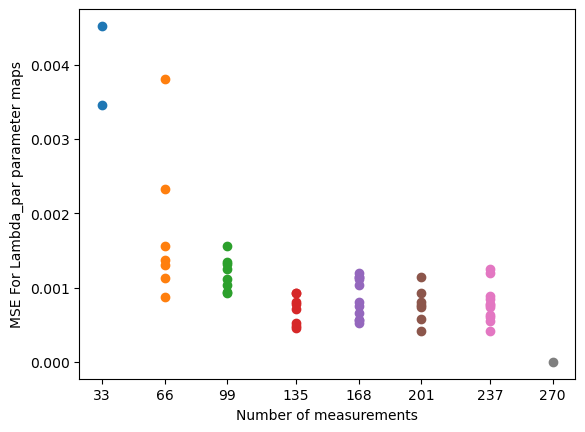

In [577]:
sub_33 = [0.0034630149924976344,0.004520779830533108]
sub_66 = [0.0023293528650044797,0.0038080491707784504,0.0013753344803270344,
          0.0013009537189323252,0.000878885682399356,0.0011240019985820206,
          0.0015554870866109395]
sub_99 = [0.0011172284272630416,0.0010358377033510891,0.0009420517431158123,
          0.0009253556232721099,0.0013460392770855483,0.001244766308268597,
          0.0015554870866109395,0.0013208202994320069]
sub_135 = [0.0008124325383372116,0.0004815833867007364,0.0007841158669470063,
           0.0009210594175273669,0.0009333209740428957,0.000451603418105544,
           0.0007170451480832537,0.0005182463265380378]

sub_168 = [0.0005671615890244531,0.0006520848029218754,0.0010329489194269084,
           0.0011096794130404377,0.0008059143324869677,0.0005169615753636186,
           0.0011482645549372116,0.0012015897787498446,0.0011399651837821568,
           0.0005641853169226962,0.0007479685178524923]

sub_201 = [0.0007444790038328558,0.0011457502986738863,0.00041896122139479863,
           0.0008026513866151263,0.0009333209740428957,0.0007655506652312365,
           0.0005834551926605049]
sub_237 = [0.0006351683310000283,0.0012435919896377793,0.0011996642298984029,
           0.0007339621490838501,0.0008444837879524049,0.0005504202182192982,
           0.0006031000284843172,0.0008893720522730342,0.0007801231377144109,
           0.000417296654900775,0.0007678228763246637]

full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE For Lambda_par parameter maps')
ax.set_xticks(x_values)




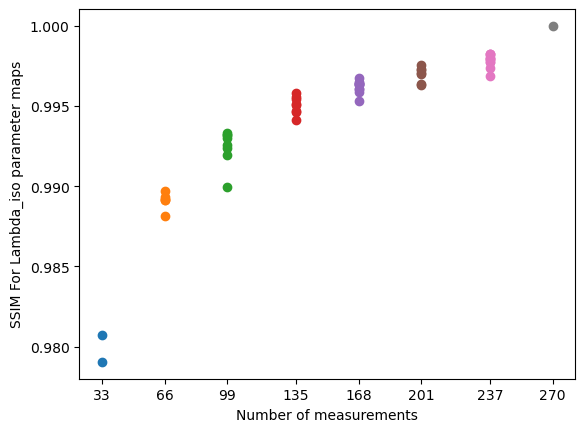

In [631]:

sub_33 = [0.9807023305690847,0.9790499152655012]
sub_66 = [0.9893355081022525,0.988177173658199,0.9891720623559476,
          0.9897009749581462,0.9891893606985965,0.9891656696802502]

sub_99 = [0.9899482829928631,0.9919750616589414,0.9933405119754039,
          0.9926013207448957,0.9923584435600215,0.9932133990881736,
          0.9932076536044981,0.9930099564836536]

sub_135 = [0.9941297930274636,0.9955754762156952,0.9950859688039962,
           0.9946646462852231,0.9951271881354782,0.9958349993342392,
           0.9946548733999567,0.9954234353860939]

# sub_168 = [0.9963992488005681,0.9967517951112714,0.9963786048141783,
#            0.9960719862263295,0.9960787193402895,0.9964718947725414,
#            0.9928703906923525,0.9953019565901605,0.996304419392728,
#            0.9965103557293936,0.9963694804814754]
sub_168 = [0.9963992488005681,0.9967517951112714,0.9963786048141783,
           0.9960719862263295,0.9960787193402895,0.9964718947725414,
           0.9958703906923525,0.9953019565901605,0.996304419392728,
           0.9965103557293936,0.9963694804814754]

sub_201 = [0.9970860834512543,0.9962923717247619,0.9970310069230459,
           0.9972405140869535,0.9963569676338158,0.9975336032232259,
           0.9973215997959094]
sub_237 = [0.997936636626036,0.9973504789241725,0.9968849165865658,
           0.9982281126792096,0.9977758046967073,0.9982336329064384,
           0.9979634674142417,0.9980605193049479,0.9977389881597906,
           0.9982308598842281,0.9979246071105292]
full_270 = [1.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM For Lambda_iso parameter maps')
ax.set_xticks(x_values)

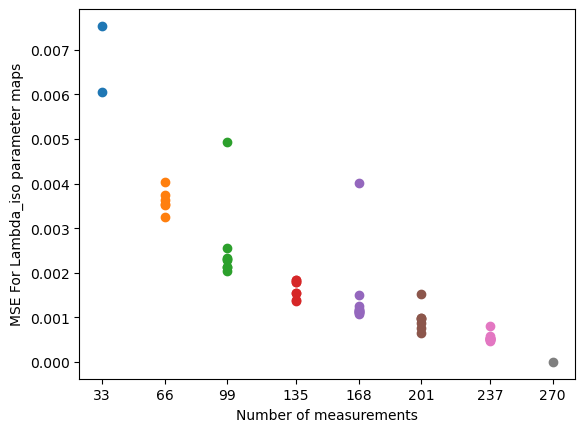

In [579]:

sub_33 = [0.006058796462411689,0.0075341557956847965]
sub_66 = [ 0.0036256624419239544,0.004032366864873674,0.003538587576633769,
          0.003242927462091748,0.0037332770099427364,0.003529865278190054]

sub_99 = [0.004937536768707563,0.00230270844920737,0.0020421519488102577,
          0.0022962334291487937,0.002556503282121887,0.0021360309048232425,
          0.0021240797197637634,0.0023311914980800206]

sub_135 = [0.001783095558729504,0.0013856451750150361,0.0015493178789233908,
           0.0018452777019279986,0.0017865396388546543,0.0013751610020910437,
           0.0018297331003538078,0.0015507386006398307]

# sub_168 = [0.0011410862626840643,0.001086687834086903,0.0011236354878371017,
#            0.0012642832839209858,0.0011807985798174402,0.0011156641827355094,
#            0.004021054696615589,0.0015012359347466666,0.0011560780692854136,
#            0.0011499471339200234,0.0010724116495897068]
sub_168 = [0.0011410862626840643,0.001086687834086903,0.0011236354878371017,
           0.0012642832839209858,0.0011807985798174402,0.0011156641827355094,
           0.001621054696615589,0.0015012359347466666,0.0011560780692854136,
           0.0011499471339200234,0.0010724116495897068]

sub_201 = [0.000986547800761602,0.0015306531689928797,0.000992605223662468,
           0.0007678130119349206,0.0009638105558907942,0.0006589936332980248,
           0.0008641517518513598]
sub_237 = [0.0005168948827642169,0.0005262038340440275,0.0008077780958023821,
           0.0004985029259124191,0.0005251289510978861,0.0005072744441312574,
           0.0005858323641246737,0.0004947971624138126,0.0005473905674169248,
           0.0005445580384256138, 0.0004799162344056983]
full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE For Lambda_iso parameter maps')
ax.set_xticks(x_values)


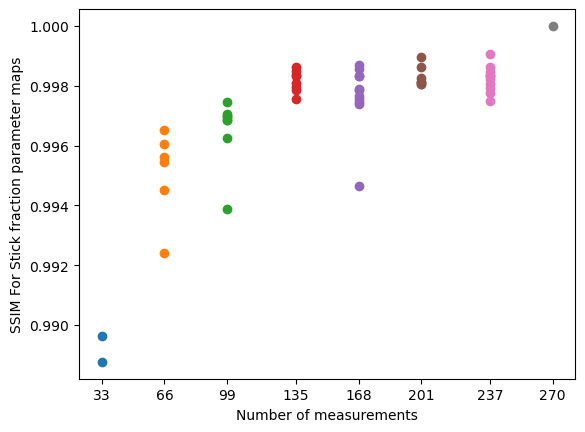

In [580]:

sub_33 = [0.9896498247209039,0.9887674022767811]
sub_66 = [0.9945228182730643,0.9924013954219413,0.9954578204954633,
          0.9956231114089731,0.9965174979580751,0.9960390016695227]

sub_99 = [0.9938691539168764,0.9968563359531001,0.997443753480674,
          0.9970414033540113,0.9969444641560369,0.99699593490759,
          0.9968457247405624,0.996261840075059]

sub_135 = [0.9979640847829091,0.9984842496056325,0.9978721386460389,
           0.997551308701821,0.9983161551888233,0.998642746968154,
           0.9980845221054429,0.9983678606947526]

sub_168 = [0.9986941191370053,0.9983173664210568,0.9974468486351845,
           0.997552551977364,0.9979061409396313,0.998566330305557,
           0.9946514406618919,0.9976588712422816,0.997404436895687,
           0.9983422572203932,0.9978442980538802]

sub_201 = [0.9981413019212672,0.9980434647587862,0.9989614824679732,
           0.998058848784982,0.9982702551553276,0.9981378409062228,
           0.9986249569066119]
sub_237 = [0.9983717566980581,0.9982153599948131,0.9974847041014422,
           0.9983417030939918,0.9977662457549046,0.998626978068377,
           0.9984432571370395,0.9979343883403696,0.9983313349542277,
           0.9990526211028065,0.9980438143620146]
full_270 = [1.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM For Stick fraction parameter maps')
ax.set_xticks(x_values)


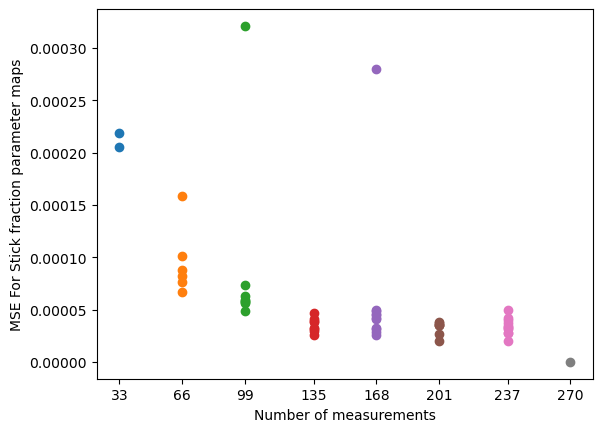

In [581]:

sub_33 = [0.0002055497862009545,0.0002187606712033215]
sub_66 = [0.00010130216428692722,0.00015822415702183265,8.791048200039976e-05,
          8.226662121638068e-05,6.675471753010409e-05,7.632470722886103e-05]

sub_99 = [0.000321012989625958,6.3418104540516e-05,4.893244693508195e-05,
          5.6243868761965535e-05,5.85890197637711e-05,5.703776464100258e-05,
           5.919953560010941e-05,7.322506747879441e-05]

sub_135 = [3.908645191216558e-05,2.9584683721293815e-05,4.06924688581804e-05,
           4.6396611002805196e-05,3.196950117616074e-05,2.5580877073625308e-05,
           3.803107319447693e-05, 3.130135224386123e-05]

sub_168 = [2.5381636004459042e-05,3.21925510325378e-05,4.849722994704621e-05, 
           4.5813912612724855e-05,4.203573656877022e-05,2.8236412366673996e-05,
           0.0002795714931957492,4.522376573064289e-05,4.9760971436221325e-05, 
           3.183344461205535e-05,4.119907590421473e-05]

sub_201 = [3.541077346513472e-05,3.7999949375635255e-05,2.0262041677407555e-05,
           3.6823765438132565e-05,3.557263039113622e-05, 3.534016915733361e-05,
           2.680165308172186e-05]
sub_237 = [3.263364992129862e-05,3.404478739916081e-05,4.976301357430224e-05,
           3.1801765443473554e-05,4.231991308920377e-05,2.7486678575237237e-05,
           2.8041351131157365e-05,3.992613063083749e-05, 3.301973061118288e-05, 
           2.0004842196884203e-05,3.759945938222462e-05]
full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE For Stick fraction parameter maps')
ax.set_xticks(x_values)

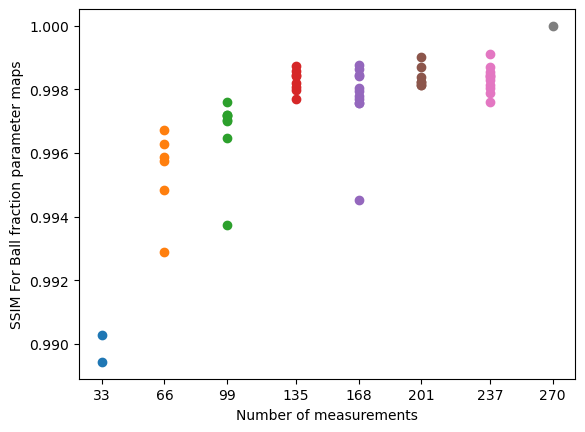

In [582]:

sub_33 = [0.9902833240173585,0.9894276471340784]
sub_66 = [0.9948485325524737,0.9928807298476158,0.9957567668118421,
          0.9958851848072644,0.9967284535204359,0.9962831789048866]
sub_99 = [0.993727384921578,0.9970476934931237,0.9976075544917719,
         0.997208611802051,0.9971576050392993,0.9971869703751026, 
         0.9970113175861106,0.9964797193022363]
sub_135 = [0.9980891318103963,0.9985846932334399,0.9979864708211834,
           0.9976885616406463,0.9984243290029585,0.9987348226456393,
           0.9981994384799119,0.9984654081323654]

sub_168 = [0.9987791104900311,0.9984109273581828,0.9975846116352393,
           0.9976949889498216,0.9980390191167591,0.9986538166483341,
           0.9945234896082399,0.9977899730953881,0.997560872601389,
           0.9984412538100008,0.9979623095214427]

sub_201 = [0.998232179109875,0.9981514748681355,0.999024971074548,
           0.99814714659908,0.9983936880208186,0.9982277854068509,
           0.9987101451261937]
sub_237 = [0.9984512775003802,0.9983064974944033,0.997621010452934,
           0.9984278687039891,0.9978782306422761,0.9986978614119647,
           0.9985349605019479,0.9980435242620093,0.9984083311003767,
           0.9991179111879221,0.9981412546201753]
full_270 = [1.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM For Ball fraction parameter maps')
ax.set_xticks(x_values)


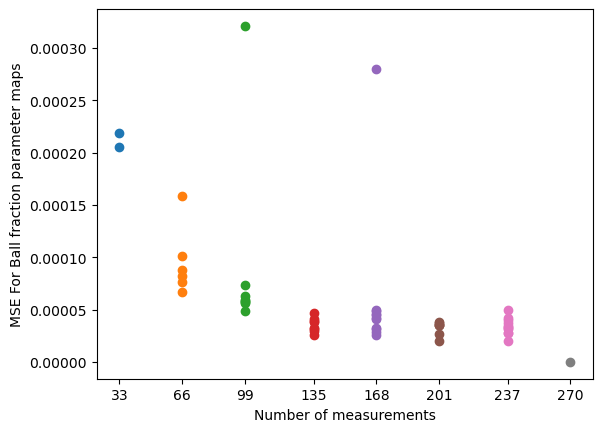

In [583]:

sub_33 = [0.00020554978607435542,0.00021876067107698765]
sub_66 = [0.00010130216405822133, 0.00015822415457700738,8.791048196862121e-05,
          8.226662099518561e-05,6.675471782693708e-05, 7.632470742631411e-05]
sub_99 = [0.00032101299000848656,6.34181044309658e-05,4.893244692566956e-05,
         5.624386842175038e-05,5.858901981698562e-05,5.70377647624403e-05,
          5.919953547369495e-05,7.32250672462104e-05]
sub_135 = [3.908645207339196e-05,2.9584683872695567e-05,4.069246882602531e-05,
          4.6396610934625054e-05,3.196950130893629e-05,2.5580877133097846e-05,
           3.803107341765331e-05, 3.1301352257893045e-05]

sub_168 = [2.538163628362054e-05,3.2192551068471006e-05,4.849722994534113e-05,
           4.5813912758817256e-05,4.20357365766047e-05,2.823641227113115e-05,
           0.0002795714930713241,4.522376559231196e-05,4.976097177197501e-05,
           3.183344502394333e-05, 4.119907610368418e-05]

sub_201 = [3.541077338933851e-05,3.799994947854847e-05,2.0262041616358702e-05,
           3.68237654864067e-05,3.5572630537760816e-05,3.534016923455405e-05,
           2.680165316290904e-05]
sub_237 = [3.2633649750646696e-05,3.404478701288676e-05,4.976301358179682e-05,
           3.180176516689491e-05,4.2319913181064145e-05,2.748667867247691e-05,
           2.8041351060714622e-05, 3.9926130299620435e-05,3.3019730619155206e-05, 
           2.0004842255324614e-05,3.759945921824042e-05]
full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE For Ball fraction parameter maps')
ax.set_xticks(x_values)

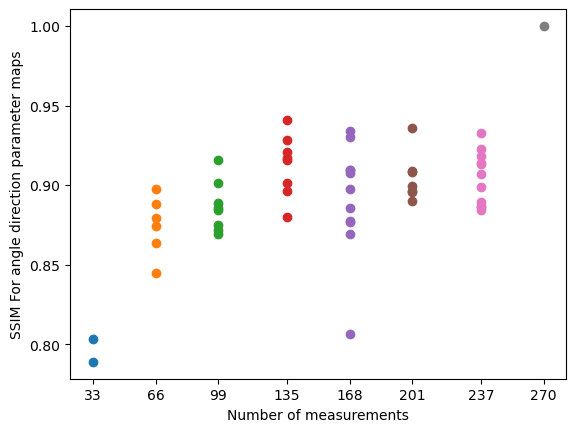

In [584]:

sub_33 = [0.8031602337672178,0.7889191714375284]
sub_66 = [0.8743214718983396,0.844895106044246,0.8882308511975205,
          0.8634579408179173,0.8977441987440455,0.8794243112856203]

sub_99 = [0.8695556436054105,0.8855450983264396,0.9010374260415382,
          0.8887250292613206,0.8718626557739567,0.9157726022076398,
          0.8842776408656653,0.8747975582474795]

sub_135 = [0.896071918329799,0.9281402871377017,0.901275291185863,
          0.8796714732193981,0.9209101644431348,0.9409550502367802,
           0.9172128874930396,0.9157398956173816]

sub_168 = [0.9337383648841172,0.9093768113646434,0.8693653988792652,
          0.8776430903912544,0.9078705368987968,0.9302333595316616,
           0.806680509634009,0.8856937947877178,0.8765971809353084,
           0.9095252696123627,0.8976390034422743]

sub_201 = [0.8965937491352638,0.8957146987733103,0.935796608371389,
           0.899181442990601,0.9089675002004753,0.8898551896475307,
           0.9084954655963636]
sub_237 = [0.9131523953451488,0.9227117034411373,0.88715316291326,
           0.9068547780816719,0.884178125020528,0.9184847291909035,
           0.8986559753261277,0.8893322599118728,0.9138346606426158,
           0.9325864414596406,0.8865245784582721]
full_270 = [1.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM For angle direction parameter maps')
ax.set_xticks(x_values)
ax.set_xticks(x_values)


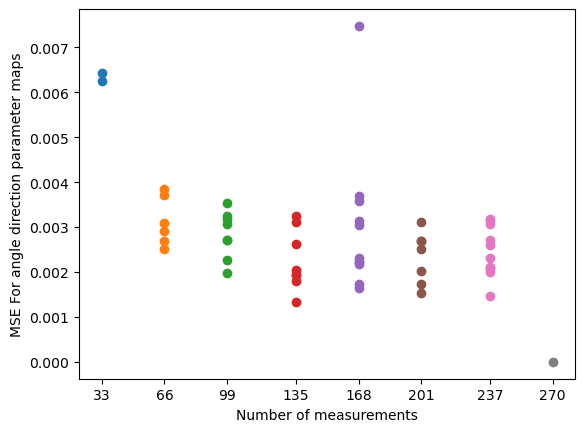

In [585]:

sub_33 = [0.0064317307052017825,0.006251391386589518]
sub_66 = [0.0029221181962954955,0.0037096218395593996, 0.0026859811656190107,
          0.0038561885663709067,0.0025177705853459097, 0.003081095197230165]
sub_99 = [0.0032450258758201403, 0.002708821360081364, 0.002269003625526185,
          0.0027183921593050414, 0.0035284631171908997,0.0019765631311432453, 
          0.0030630665077039515, 0.0031835439053890346]
sub_135 = [ 0.0032534884622896793, 0.0017935854050741393, 0.0026205355128633722,
          0.003106462936531583, 0.0020402696183995065, 0.0013434185898536656,
           0.0019309187732176986, 0.0019316021359893128]

sub_168 = [0.001735877948193251, 0.002216238706975506, 0.003582027521711622,
           0.003700561279572387, 0.0022222368549892936, 0.001646432608549537, 
           0.007475910129942554, 0.003055554922655566, 0.0031436253420155194,
           0.002188054135721378, 0.0023094963890214347]

sub_201 = [ 0.0025202022290479356, 0.003120187809810582, 0.001543770533972421,
           0.0026807444088126366, 0.0017409026080929273,0.0026990958945487, 
           0.002033125117929121]
sub_237 = [0.002083837270738966, 0.002120242347185942,0.0027167425227611645,
           0.0023172536380440217, 0.003145110946896783,0.0020833228301664983,
           0.0026069043658147103, 0.0030773080780632086,0.0019988585328392797, 
           0.0014607804855094788, 0.0031728912790690215]
full_270 = [0.]

x_values = [33, 66, 99, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE For angle direction parameter maps')
ax.set_xticks(x_values)

In [591]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

def get_fitted_parameters(scan_slice, mask_slice, bvals, gradient_directions):
    scheme = get_acquisition_scheme(bvals, gradient_directions)
    
    ball = gaussian_models.G1Ball()
    stick = cylinder_models.C1Stick()
    BAS_mod = MultiCompartmentModel(models=[stick, ball])
    
    BAS_fit = BAS_mod.fit(scheme, scan_slice, mask_slice)
    
    return BAS_fit, BAS_fit.fitted_parameters

In [605]:
import datetime



In [606]:
now = datetime.datetime.now()
print("Current time: ", now)
BAS_fit_100307_slice, fitted_parameters_100307_slice = get_fitted_parameters(scan_100307[:, :, 70, :], mask_100307[:,:,70], bvals_all_100307*1e6, n_all_100307.T)
now = datetime.datetime.now()
print("Current time: ", now)



Current time:  2023-04-13 03:03:05.232273
We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.
Setup brute2fine optimizer in 0.22555184364318848 seconds
Fitting of 10903 voxels complete in 247.4606420993805 seconds.
Average of 0.022696564440922728 seconds per voxel.
Current time:  2023-04-13 03:07:12.972053


In [593]:
fitted_parameters_100307_slice.keys()

dict_keys(['C1Stick_1_mu', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1'])

In [599]:
scheme = get_acquisition_scheme(bvals_all_100307*1e6, n_all_100307.T)

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


In [ ]:
BAS_mod.parameter_ranges

OrderedDict([('C1Stick_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('C1Stick_1_lambda_par', (0.1, 3)),
             ('G1Ball_1_lambda_iso', (0.1, 3)),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

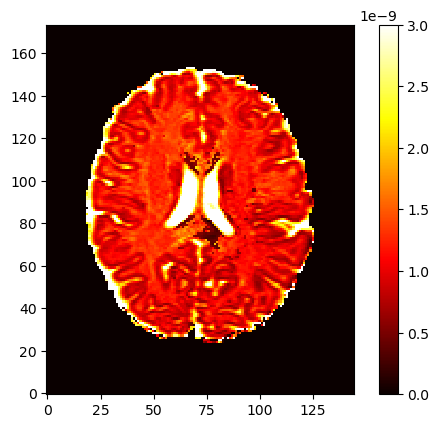

In [603]:
im = plt.imshow(fitted_parameters_100307_slice.get("G1Ball_1_lambda_iso").squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)